In [1]:
!pip install tensorflow tensorflow-quantum cirq
!pip install pennylane --upgrade

In [5]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train[:1000]
y_train = y_train[:1000]
x_test  = x_test[:200]
y_test  = y_test[:200]

def preprocess(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.image.resize(x, (4, 4))
    x = tf.cast(x, tf.float32) / 255.0
    x = tf.reshape(x, (-1, 4, 4))
    x = tf.reduce_mean(x, axis=2)
    return x

x_train_p = preprocess(x_train)
x_test_p  = preprocess(x_test)

#cnn

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(10)
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

cnn_history = cnn_model.fit(
    x_train_p, y_train,
    validation_data=(x_test_p, y_test),
    epochs=10,
    batch_size=32
)

#circuit
n_qubits = 4
qubits = cirq.GridQubit.rect(1, n_qubits)

x_symbols = sympy.symbols("x0:4")
theta_symbols = sympy.symbols("theta0:4")

encoding_circuit = cirq.Circuit()
for i in range(4):
    encoding_circuit.append(cirq.ry(x_symbols[i])(qubits[i]))

trainable_circuit = cirq.Circuit()
for i in range(4):
    trainable_circuit.append(cirq.ry(theta_symbols[i])(qubits[i]))

for i in range(4):
    trainable_circuit.append(
        cirq.CZ(qubits[i], qubits[(i + 1) % 4])
    )

readout = [cirq.Z(qubits[0])]

def build_circuits(x):
    circuits = []
    x_np = x.numpy()

    for sample in x_np:
        resolver = {x_symbols[i]: float(sample[i]) for i in range(4)}
        resolved = cirq.resolve_parameters(encoding_circuit, resolver)
        circuits.append(resolved)

    return tfq.convert_to_tensor(circuits)

x_train_circuits = build_circuits(x_train_p)
x_test_circuits  = build_circuits(x_test_p)

#qnn model

quantum_layer = tfq.layers.PQC(
    model_circuit=trainable_circuit,
    operators=readout
)

qnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    quantum_layer,
    tf.keras.layers.Dense(10)
])

qnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

qnn_history = qnn_model.fit(
    x_train_circuits, y_train,
    validation_data=(x_test_circuits, y_test),
    epochs=10,
    batch_size=32
)

#plotting

plt.figure(figsize=(10,6))
plt.plot(cnn_history.history["accuracy"], label="CNN Train", linestyle="-")
plt.plot(cnn_history.history["val_accuracy"], label="CNN Val", linestyle="--")
plt.plot(qnn_history.history["accuracy"], label="QNN Train", linestyle="-.")
plt.plot(qnn_history.history["val_accuracy"], label="QNN Val", linestyle=":")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN vs QNN Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cnn_history.history["loss"], label="CNN Train", linestyle="-")
plt.plot(cnn_history.history["val_loss"], label="CNN Val", linestyle="--")
plt.plot(qnn_history.history["loss"], label="QNN Train", linestyle="-.")
plt.plot(qnn_history.history["val_loss"], label="QNN Val", linestyle=":")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN vs QNN Loss")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0938 - loss: 2.3124 - val_accuracy: 0.0800 - val_loss: 2.2940
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0678 - loss: 2.3057 - val_accuracy: 0.1250 - val_loss: 2.2909
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0967 - loss: 2.3006 - val_accuracy: 0.1600 - val_loss: 2.2887
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1244 - loss: 2.2965 - val_accuracy: 0.1700 - val_loss: 2.2869
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1256 - loss: 2.2894 - val_accuracy: 0.1500 - val_loss: 2.2851
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1509 - loss: 2.2846 - val_accuracy: 0.1400 - val_loss: 2.2843
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1467 - loss: 2.2827 - val_accuracy: 0.1450 - val_loss: 2.2834
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1423 - loss: 2.2764 - val_accuracy: 0.1400 - val_loss

TypeError: Layer.add_weight() got multiple values for argument 'shape'

Keras 3 seems to be incompatible. Switching to Pytorch.

In [1]:
#installing required packages
!pip install pennylane torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 115.2 MB/s eta 0:00:00


Epoch 0: QNN Acc=0.094, CNN Acc=0.100
Epoch 10: QNN Acc=0.094, CNN Acc=0.129
Epoch 20: QNN Acc=0.094, CNN Acc=0.124
Epoch 30: QNN Acc=0.106, CNN Acc=0.141
Epoch 40: QNN Acc=0.116, CNN Acc=0.147


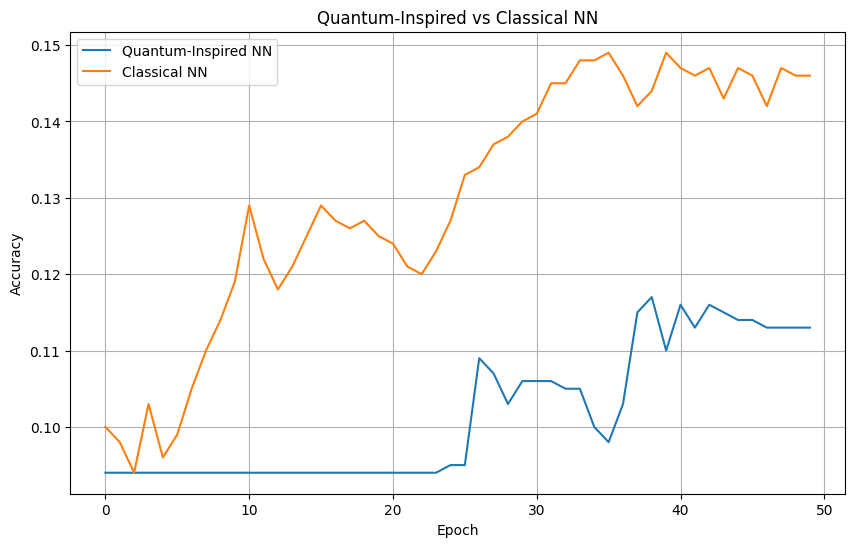

In [11]:
#test code
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

n_qubits = 4
epochs = 50
lr = 0.01

torch.manual_seed(0)

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(n_qubits))

    def forward(self, x):
        """
        x shape: (batch, n_qubits)
        """

        encoded = torch.sin(x)
        rotated = torch.sin(encoded + self.theta)
        entangled = rotated.clone()

        for i in range(n_qubits):
            entangled[:, i] = rotated[:, i] * rotated[:, (i + 1) % n_qubits]

        return torch.cos(entangled)

#model
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = QuantumLayer(n_qubits)
        self.fc = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.q_layer(x)
        return self.fc(x)

model = HybridQNN()

#baseline
class ClassicalNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        return self.net(x)

cnn = ClassicalNN()

#dummy dataset
X = torch.rand(1000, 4)
y = torch.randint(0, 10, (1000,))

X_test = torch.rand(200, 4)
y_test = torch.randint(0, 10, (200,))

#training
loss_fn = nn.CrossEntropyLoss()

opt_qnn = optim.Adam(model.parameters(), lr=lr)
opt_cnn = optim.Adam(cnn.parameters(), lr=lr)

qnn_acc, cnn_acc = [], []

for epoch in range(epochs):
    #qnn
    opt_qnn.zero_grad()
    q_logits = model(X)
    q_loss = loss_fn(q_logits, y)
    q_loss.backward()
    opt_qnn.step()

    q_pred = q_logits.argmax(dim=1)
    q_acc = (q_pred == y).float().mean().item()
    qnn_acc.append(q_acc)

    #cnn
    opt_cnn.zero_grad()
    c_logits = cnn(X)
    c_loss = loss_fn(c_logits, y)
    c_loss.backward()
    opt_cnn.step()

    c_pred = c_logits.argmax(dim=1)
    c_acc = (c_pred == y).float().mean().item()
    cnn_acc.append(c_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: QNN Acc={q_acc:.3f}, CNN Acc={c_acc:.3f}")

#plotting
plt.figure(figsize=(10,6))
plt.plot(qnn_acc, label="Quantum-Inspired NN")
plt.plot(cnn_acc, label="Classical NN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Quantum-Inspired vs Classical NN")
plt.legend()
plt.grid(True)
plt.show()


CNNBaseline | Epoch 01 | Train: 0.105 | Test: 0.106
CNNBaseline | Epoch 02 | Train: 0.108 | Test: 0.119
CNNBaseline | Epoch 03 | Train: 0.124 | Test: 0.128
CNNBaseline | Epoch 04 | Train: 0.134 | Test: 0.138
CNNBaseline | Epoch 05 | Train: 0.144 | Test: 0.138
CNNBaseline | Epoch 06 | Train: 0.136 | Test: 0.150
CNNBaseline | Epoch 07 | Train: 0.143 | Test: 0.145
CNNBaseline | Epoch 08 | Train: 0.145 | Test: 0.155
CNNBaseline | Epoch 09 | Train: 0.144 | Test: 0.152
CNNBaseline | Epoch 10 | Train: 0.150 | Test: 0.160
QNNSurrogate | Epoch 01 | Train: 0.098 | Test: 0.086
QNNSurrogate | Epoch 02 | Train: 0.098 | Test: 0.086
QNNSurrogate | Epoch 03 | Train: 0.098 | Test: 0.086
QNNSurrogate | Epoch 04 | Train: 0.098 | Test: 0.088
QNNSurrogate | Epoch 05 | Train: 0.111 | Test: 0.106
QNNSurrogate | Epoch 06 | Train: 0.132 | Test: 0.119
QNNSurrogate | Epoch 07 | Train: 0.139 | Test: 0.119
QNNSurrogate | Epoch 08 | Train: 0.131 | Test: 0.130
QNNSurrogate | Epoch 09 | Train: 0.136 | Test: 0.137
QNN

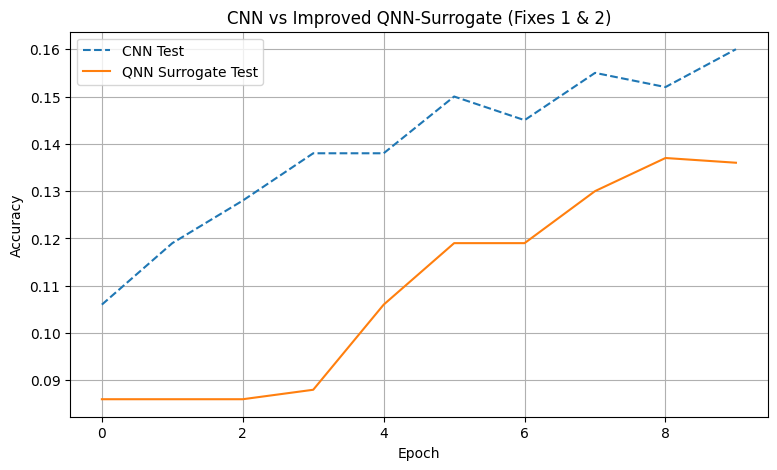

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 10
lr = 1e-3

#preprocessing
transform = T.Compose([
    T.Grayscale(),
    T.Resize((4, 4)),
    T.ToTensor()
])

def reduce_to_4d(x):
    return x.mean(dim=2).squeeze(1)  # (B,1,4,4) → (B,4)

def load_and_cache(dataset, limit=None):
    xs, ys = [], []
    for i, (img, label) in enumerate(dataset):
        if limit and i >= limit:
            break
        img = transform(img)
        xs.append(reduce_to_4d(img.unsqueeze(0)))
        ys.append(label)
    return torch.cat(xs), torch.tensor(ys)

train_raw = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True
)
test_raw = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True
)

x_train, y_train = load_and_cache(train_raw, limit=5000)
x_test,  y_test  = load_and_cache(test_raw,  limit=1000)

x_train, y_train = x_train.to(device), y_train.to(device)
x_test,  y_test  = x_test.to(device),  y_test.to(device)

train_loader = DataLoader(
    TensorDataset(x_train, y_train),
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    TensorDataset(x_test, y_test),
    batch_size=batch_size,
    shuffle=False
)

#baseline cnn
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        return self.net(x)

#qnn
class QNNSurrogate(nn.Module):
    """
    QNN-inspired model with:
    - angle encoding
    - depth = 2
    - ring-style entanglement
    - multi-qubit measurement (4 outputs)
    """
    def __init__(self):
        super().__init__()

        self.theta1 = nn.Parameter(torch.randn(4))
        self.theta2 = nn.Parameter(torch.randn(4))

        self.mix1 = nn.Parameter(torch.randn(4, 4))
        self.mix2 = nn.Parameter(torch.randn(4, 4))

        self.readout = nn.Linear(4, 10)

    def forward(self, x):
        #layer 1
        x = torch.sin(x + self.theta1)
        x = x @ self.mix1

        #layer 2
        x = torch.sin(x + self.theta2)
        x = x @ self.mix2

        # qbit measurement
        z = torch.tanh(x)

        return self.readout(z)


def train_model(model):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_acc, test_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0

        for x, y in train_loader:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_acc.append(correct / total)

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in test_loader:
                logits = model(x)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        test_acc.append(correct / total)

        print(
            f"{model.__class__.__name__} | "
            f"Epoch {epoch+1:02d} | "
            f"Train: {train_acc[-1]:.3f} | "
            f"Test: {test_acc[-1]:.3f}"
        )

    return train_acc, test_acc


cnn_train, cnn_test = train_model(CNNBaseline())
qnn_train, qnn_test = train_model(QNNSurrogate())

#plotting
plt.figure(figsize=(9,5))
plt.plot(cnn_test, label="CNN Test", linestyle="--")
plt.plot(qnn_test, label="QNN Surrogate Test", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN vs Improved QNN-Surrogate (Fixes 1 & 2)")
plt.legend()
plt.grid(True)
plt.show()
